## Tuned Model: Updating model with holdout dataset.
With the recent release of the holdout dataset, we are given a chance to fine tune our models. We decided now to include both the train.csv and validation.csv dataset to train the model and then predict on the holdout dataset. Below is the process and result of this tuning. Again this notebook is structured the same as the Proof of Concept.

### Loading Libraries

In [1]:
#Standard python libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#User Utils for Plotting and Scoring
from utils2 import plot_pred, metric_report,event_encoder,time_frame,feature_selection,plot_probab,add_outcome,return_outcome

### Importing Data

In [2]:
train_df = pd.read_csv('training.csv',parse_dates=['EventTime'],index_col='EventTime')
test_df  = pd.read_csv('validation.csv',parse_dates=['EventTime'],index_col='EventTime')
holdout_df= pd.read_csv('holdout.csv',parse_dates=['EventTime'],index_col='EventTime')

### Defining the Abnormal Events
For our binary classification problem, we need to define our abnormal events and utilize this information to create this binary target (**Normal** = 0 ; **Abnormal** =1)  
This binary encoding will be utilize for both training and validating the model.  
**Note:** Model was trained with a 30 min lag window on the train data to better capture the transitional period.

In [3]:
#Defining each event
Event_1 = ['2016-05-22 20:42:00','2016-05-24 16:00:00']
Event_2 = ['2016-07-17 02:30:00','2016-07-19 08:00:00']
Event_3 = ['2016-07-29 10:13:00','2016-08-01 16:00:00']
Event_4 = ['2017-08-18 14:18:00','2017-08-23 12:00:00']
Event_5 = ['2017-09-20 05:35:00','2017-09-27 12:00:00']
Event_6 = ['2017-11-04 11:45:00','2017-11-13 06:00:00']
Event_7 = ['2017-11-29 11:27:00','2017-12-01 17:00:00']
Event_8 = ['2018-02-08 04:19:00','2018-02-10 11:40:00']
Event_9 = ['2018-02-18 01:09:00','2018-02-21 12:42:00']
Event_10= ['2018-03-03 12:46:00','2018-03-08 17:58:00']

#Conversion of Events to datetime
Events_train = pd.to_datetime(Event_1+Event_2+Event_3+Event_4+Event_5+Event_6)
Events_test = pd.to_datetime(Event_7+Event_8)
Events_holdout= pd.to_datetime(Event_9+Event_10)
# Encoding the events into the dataset
train_df=event_encoder(Events_train,train_df)
test_df =event_encoder(Events_test,test_df)
holdout_df=event_encoder(Events_holdout,holdout_df)

In [4]:
combo_df = pd.concat([train_df,test_df])

## Part 1: "Warning Model" 


### Part 1: Feature Selection

In [5]:
X_train,y_train= feature_selection(combo_df,n=15)
X_test, y_test = feature_selection(holdout_df,n=15)

### Part 1: XGBoost Predictor Model

In [6]:
Warning_model = pickle.load(open("warning_model2.pickle.dat", "rb"))

### Scoring and Validation
Per dataset, we will evaluate the model on both business needs and the correct metrics for a classifer. The metrics are as follows:  
- **ROC-AUC:** ability to rank between the two classes of Normal or Abnormal  
- **Balanced Accuracy:** accuracy score accounting for imabalanced classes that is defined as the average of recall obtained on each class  
- **Confusion Matrix:**  
    - Displays the # of True Positives, True Negatives, False Positives and False Negatives  
    - Format is as follows:  
    [[True Negative  False Positive]  
     [False Negative True Positive]]  
- **Classification Report:**  
    - Overall classification metric scorecard.  
    - Display precision, recall and f1-score.      
- **Prediction vs Actuals Graphs**
  - Plot of the model predictions represented as *Normal* = 0 and *Abnormal* = 1 over the dataset period compared to the Actual Values defined by the Event Times.
  - Orange = Model Predictions  
  - Blue = True Values (**Note: We just scaled the Actual values to 2 for better graphical visiblity**)    
- **Feature Importances**    
    - Bar chart explaining what variables are important to the model and the magnitude of their importance to the model as well.    
- **Times Detected**  
    - Shows beginning and end timestamps of each event.   
    - In addition, shows the time that the model predicts that the abnormal event is starting.

=============== TRAIN ===============
          ROC AUC score: 0.9999792589512723
Balanced Accuracy score: 0.9963650445371985

	Confusion Matrix
 [[895721    320]
 [   326  46833]]


	TRAIN Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    896041
           1       0.99      0.99      0.99     47159

    accuracy                           1.00    943200
   macro avg       1.00      1.00      1.00    943200
weighted avg       1.00      1.00      1.00    943200




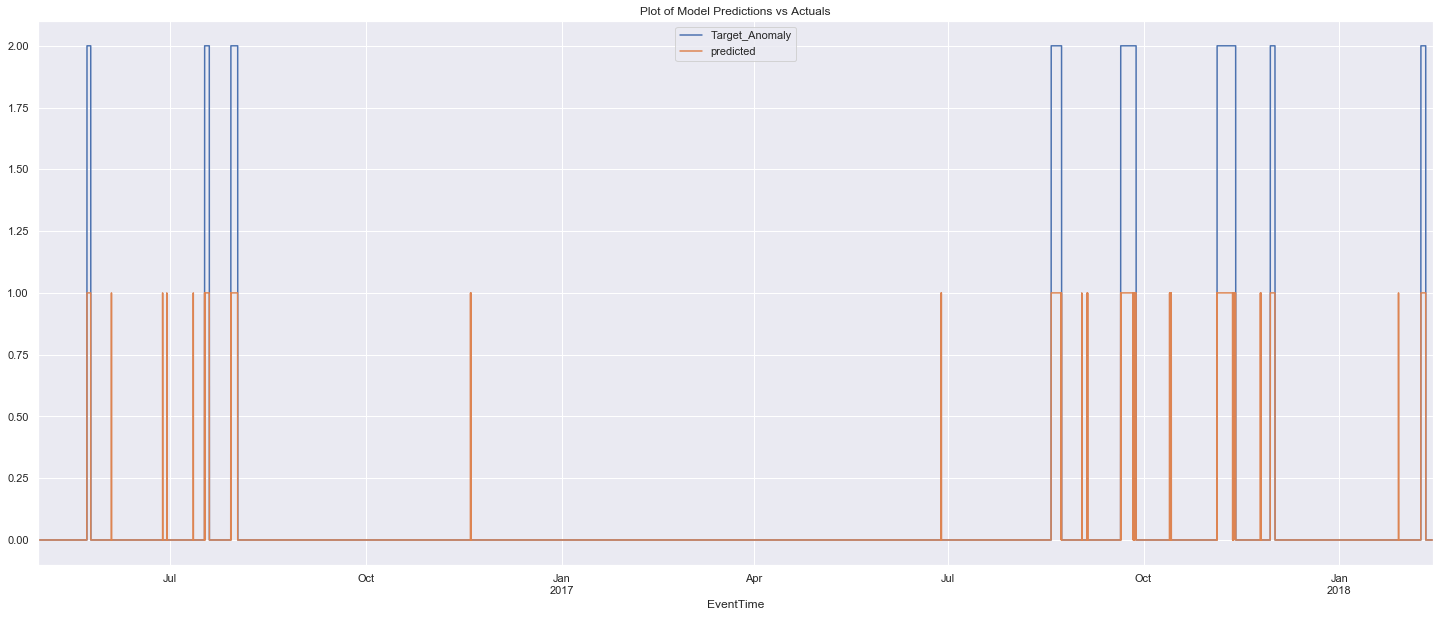

=============== TEST ===============
          ROC AUC score: 0.9981911786833807
Balanced Accuracy score: 0.9595513786838785

	Confusion Matrix
 [[33572  2860]
 [   30 12497]]


	TEST Classification Report
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     36432
           1       0.81      1.00      0.90     12527

    accuracy                           0.94     48959
   macro avg       0.91      0.96      0.93     48959
weighted avg       0.95      0.94      0.94     48959




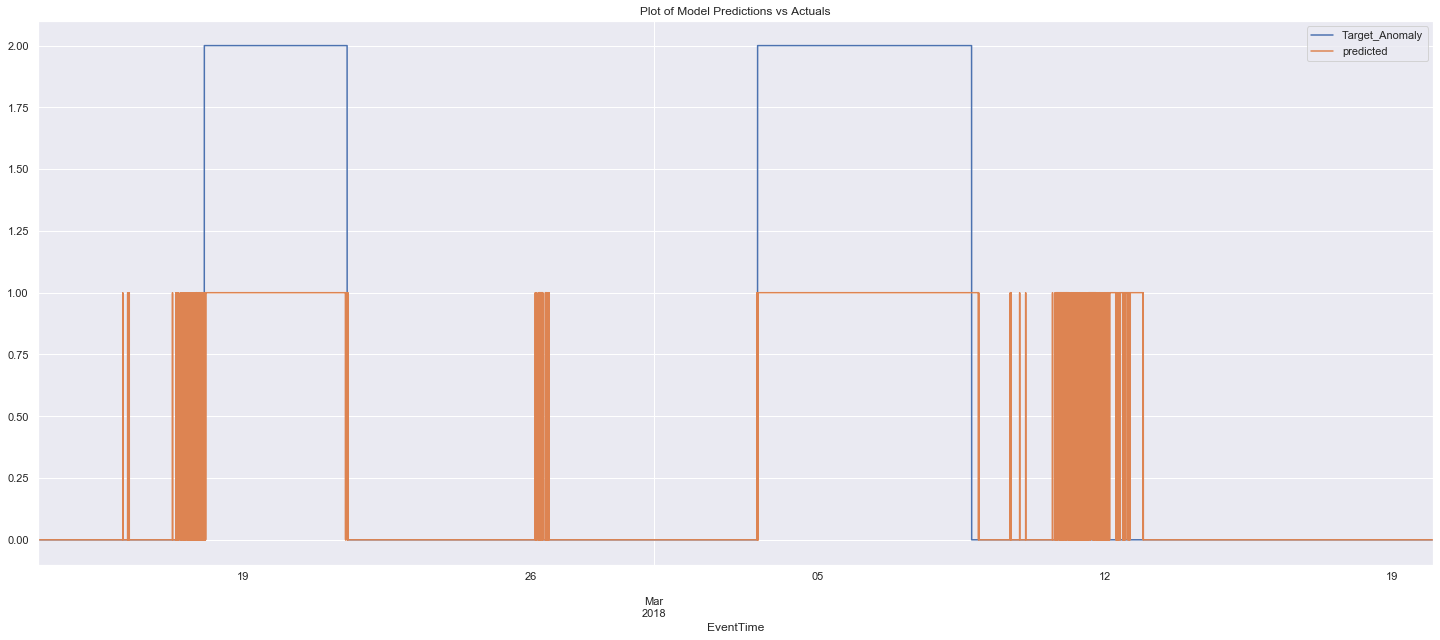

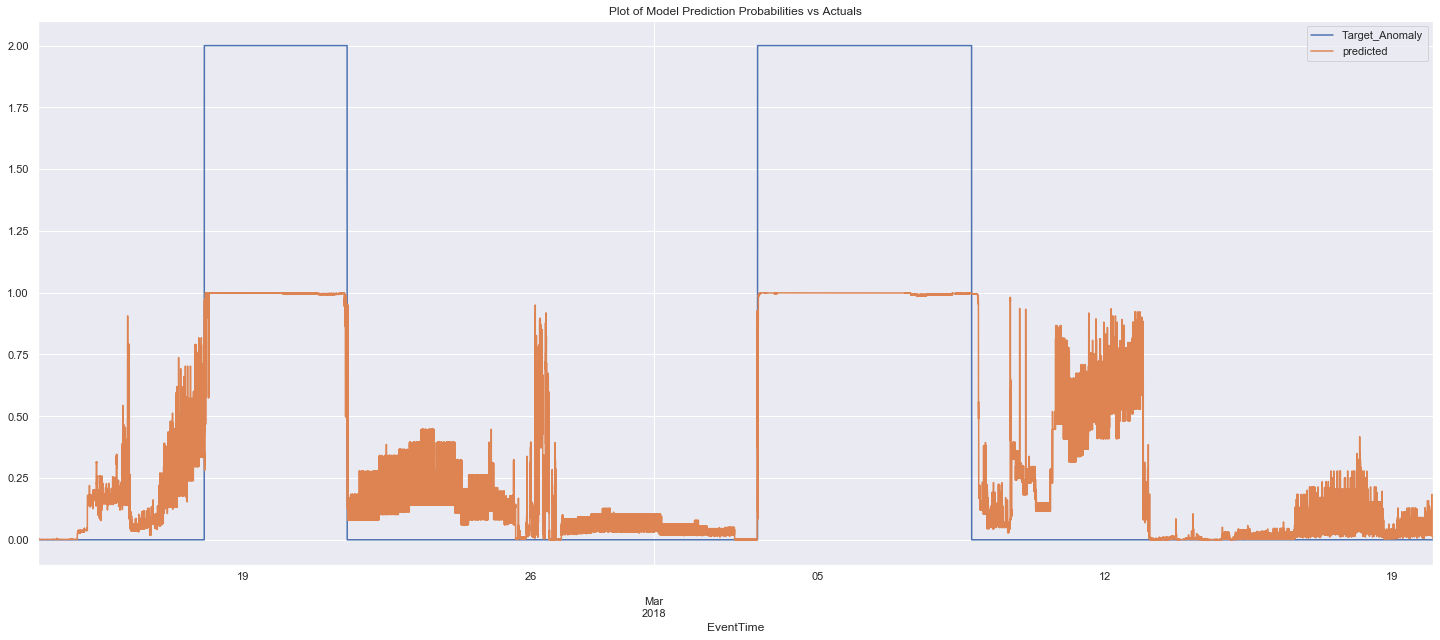

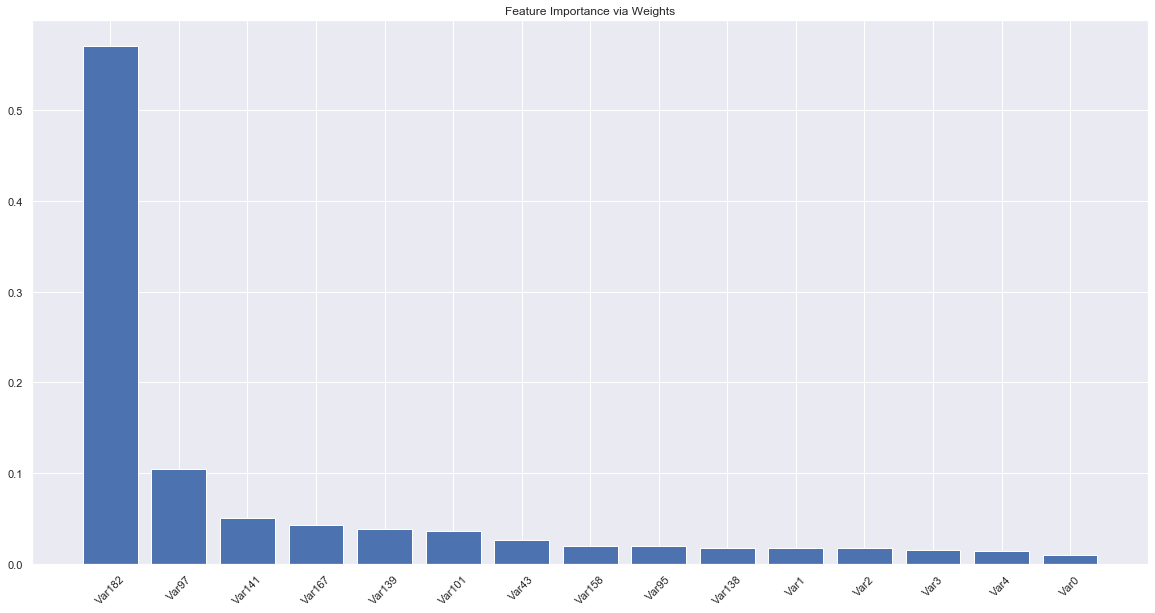

------------------- Time Detected -------------------
Showing the time that the warning model predicts that the abnormal event is starting
-------------------------- Event 1 --------------------------
 Predicted Start Anomaly Time: 2016-05-22 20:05:00.
   Predicted End Anomaly Time: 2016-05-24 15:59:00.
            Detected early by: 0 days 00:37:00

-------------------------- Event 2 --------------------------
 Predicted Start Anomaly Time: 2016-07-17 01:53:00.
   Predicted End Anomaly Time: 2016-07-19 07:43:00.
            Detected early by: 0 days 00:37:00

-------------------------- Event 3 --------------------------
 Predicted Start Anomaly Time: 2016-07-29 09:24:00.
   Predicted End Anomaly Time: 2016-08-01 15:59:00.
            Detected early by: 0 days 00:49:00

-------------------------- Event 4 --------------------------
 Predicted Start Anomaly Time: 2017-08-18 13:36:00.
   Predicted End Anomaly Time: 2017-08-23 11:54:00.
            Detected early by: 0 days 00:42:00

-----

In [7]:
#Parameters
thresh_val=0.5
modelx = Warning_model

#Metric Reports
metric_report(modelx, X_train,y_train, thresh=thresh_val,name= "TRAIN")
# plot_probab(modelx,X_train,y_train)
metric_report(modelx, X_test , y_test, thresh=thresh_val,name= "TEST")
plot_probab(modelx,X_test,y_test)
#Plotting out the weights of the model to see importance 
Start = 0
End = 30
indices = np.argsort(np.abs(modelx.feature_importances_))[::-1]
plt.figure(figsize=(20,10))
plt.title("Feature Importance via Weights")
plt.bar(X_train.columns[indices][Start:End], np.abs(modelx.feature_importances_)[indices][Start:End])
plt.xticks(X_train.columns[indices][Start:End], rotation = 45)
plt.show()

#Finding Time Frame
#Train Events
print('------------------- Time Detected -------------------')
print('Showing the time that the warning model predicts that the abnormal event is starting')
time_frame(modelx,X_train,Event_1,num=1,thresh=thresh_val)
time_frame(modelx,X_train,Event_2,num=2,thresh=thresh_val)
time_frame(modelx,X_train,Event_3,num=3,thresh=thresh_val)
time_frame(modelx,X_train,Event_4,num=4,thresh=thresh_val)
time_frame(modelx,X_train,Event_5,num=5,thresh=thresh_val)
time_frame(modelx,X_train,Event_6,num=6,thresh=thresh_val)
#Test Events
time_frame(modelx,X_train,Event_7,num=7,thresh=thresh_val)
time_frame(modelx,X_train,Event_8,num=8,early=360,thresh=thresh_val)
#Holdout Events
time_frame(modelx,X_test,Event_9,num=9,early=1440,thresh=thresh_val)
time_frame(modelx,X_test,Event_10,num=10,thresh=thresh_val)

## Part 2: "Critical Model"

### Part 2: Feature Selection


In [8]:
X_train2,y_train2= feature_selection(combo_df,n=15)
X_test2, y_test2 = feature_selection(holdout_df,n=15)

### Part 2: XGBoost Detector Model

In [9]:
Critical_model = pickle.load(open("Critical_model2.pickle.dat", "rb"))

=============== TRAIN ===============
          ROC AUC score: 0.9999792589512723
Balanced Accuracy score: 0.9842665539058064

	Confusion Matrix
 [[895871    170]
 [  1475  45684]]


	TRAIN Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    896041
           1       1.00      0.97      0.98     47159

    accuracy                           1.00    943200
   macro avg       1.00      0.98      0.99    943200
weighted avg       1.00      1.00      1.00    943200




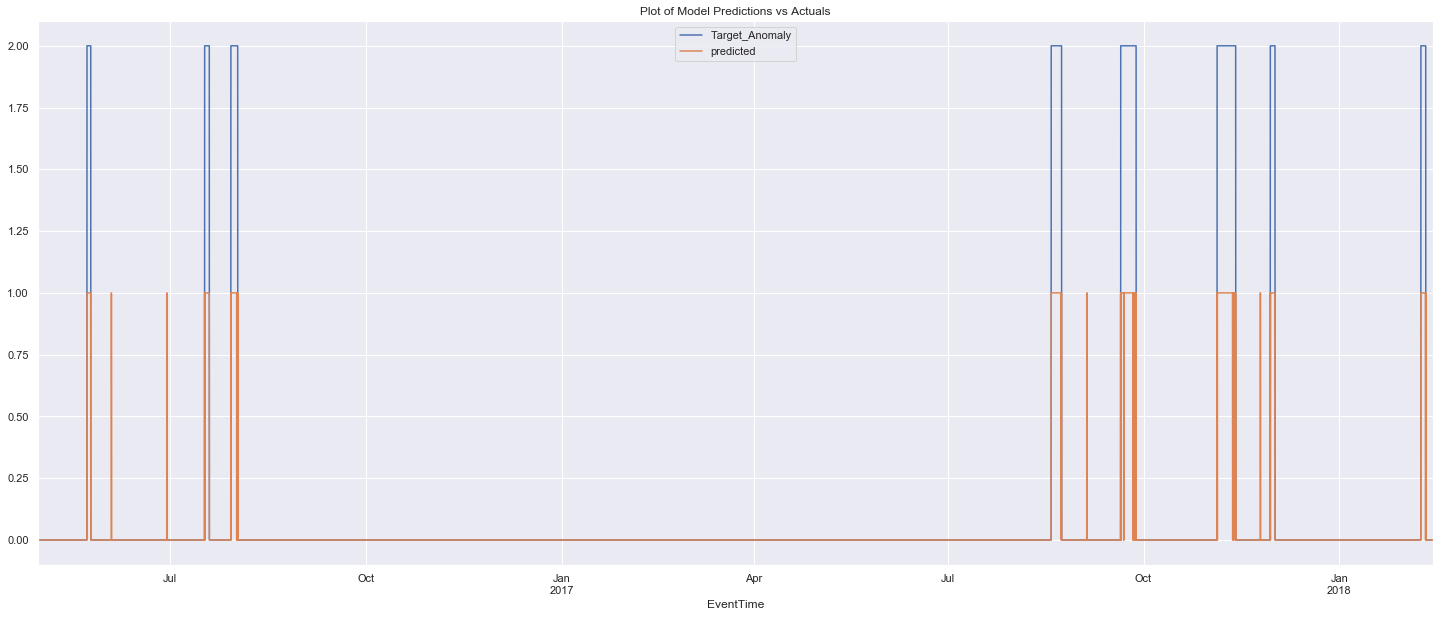

=============== TEST ===============
          ROC AUC score: 0.9981911786833807
Balanced Accuracy score: 0.9900062340969329

	Confusion Matrix
 [[36015   417]
 [  107 12420]]


	TEST Classification Report
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     36432
           1       0.97      0.99      0.98     12527

    accuracy                           0.99     48959
   macro avg       0.98      0.99      0.99     48959
weighted avg       0.99      0.99      0.99     48959




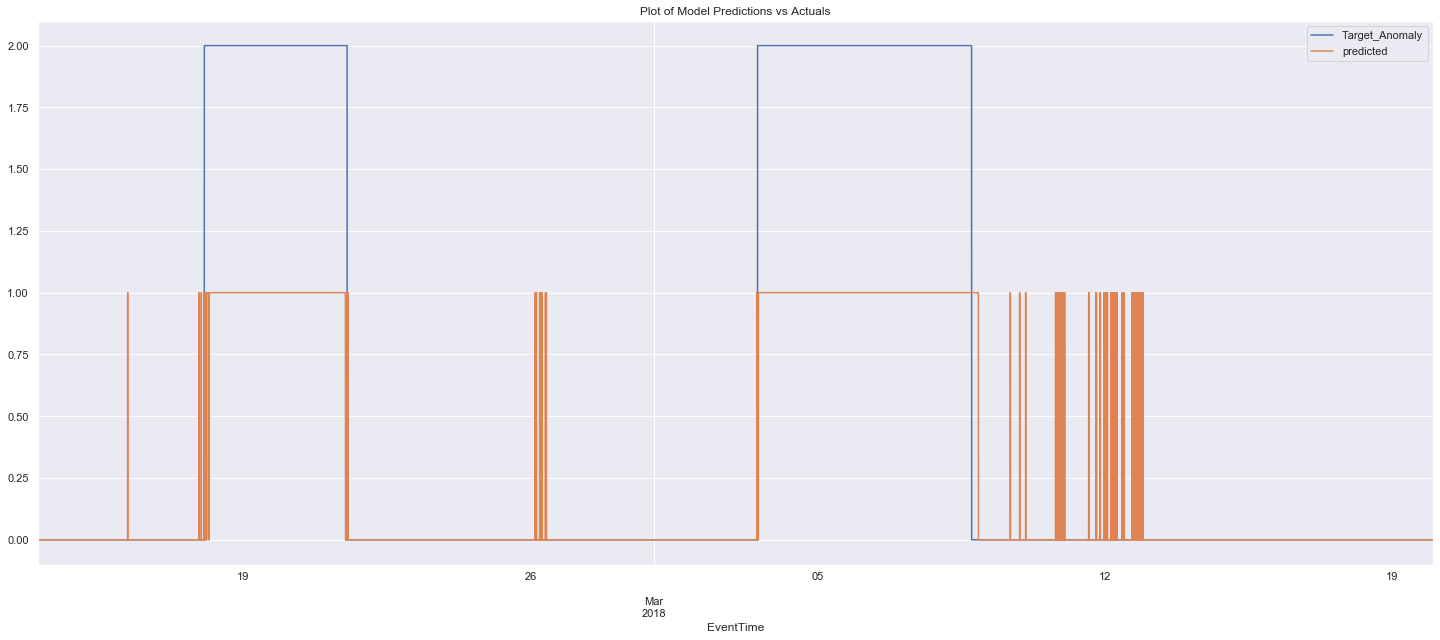

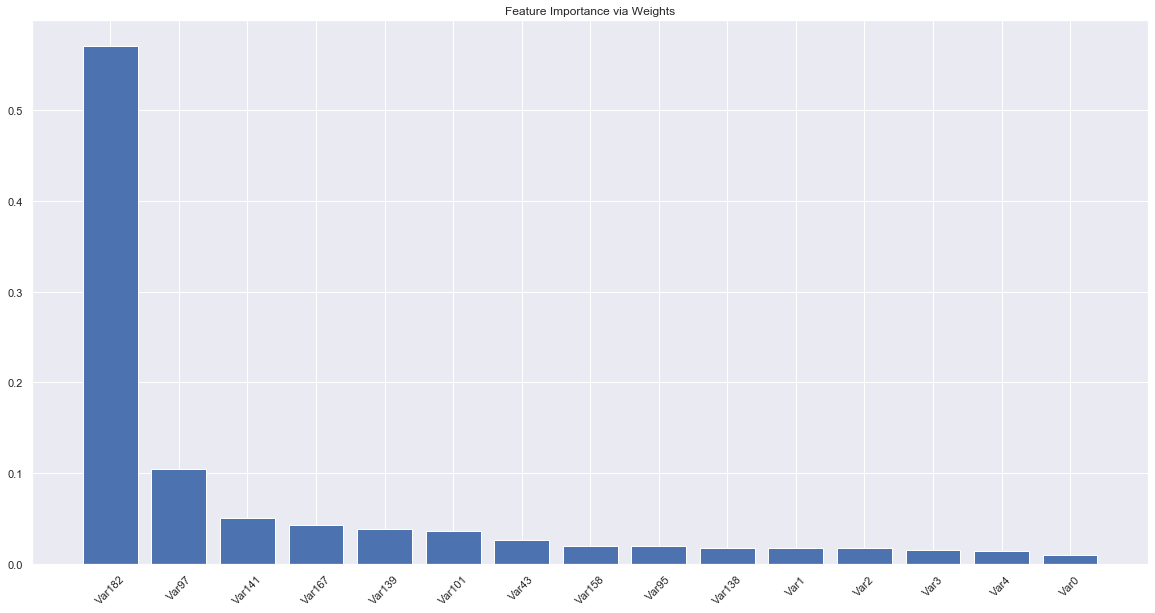

------------------- Time Detected -------------------
Showing the time that the critical model predicts that the abnormal event is starting
-------------------------- Event 1 --------------------------
 Predicted Start Anomaly Time: 2016-05-22 20:28:00.
   Predicted End Anomaly Time: 2016-05-24 15:53:00.
            Detected early by: 0 days 00:14:00

-------------------------- Event 2 --------------------------
 Predicted Start Anomaly Time: 2016-07-17 01:53:00.
   Predicted End Anomaly Time: 2016-07-19 07:43:00.
            Detected early by: 0 days 00:37:00

-------------------------- Event 3 --------------------------
 Predicted Start Anomaly Time: 2016-07-29 09:37:00.
   Predicted End Anomaly Time: 2016-08-01 15:45:00.
            Detected early by: 0 days 00:36:00

-------------------------- Event 4 --------------------------
 Predicted Start Anomaly Time: 2017-08-18 13:36:00.
   Predicted End Anomaly Time: 2017-08-23 11:52:00.
            Detected early by: 0 days 00:42:00

----

In [10]:
thresh_val=0.81
modelx = Critical_model

#Metric Reports
metric_report(modelx, X_train2,y_train2, thresh=thresh_val,name= "TRAIN")
metric_report(modelx, X_test2 , y_test2, thresh=thresh_val,name= "TEST")

#Plotting out the weights of the model to see importance 
Start = 0
End = 30
indices = np.argsort(np.abs(modelx.feature_importances_))[::-1]
plt.figure(figsize=(20,10))
plt.title("Feature Importance via Weights")
plt.bar(X_train2.columns[indices][Start:End], np.abs(modelx.feature_importances_)[indices][Start:End])
plt.xticks(X_train2.columns[indices][Start:End], rotation = 45)
plt.show()

#Finding Time Frame
#Train Events
print('------------------- Time Detected -------------------')
print('Showing the time that the critical model predicts that the abnormal event is starting')
time_frame(modelx,X_train2,Event_1,num=1,thresh=thresh_val)
time_frame(modelx,X_train2,Event_2,num=2,thresh=thresh_val)
time_frame(modelx,X_train2,Event_3,num=3,thresh=thresh_val)
time_frame(modelx,X_train2,Event_4,num=4,thresh=thresh_val)
time_frame(modelx,X_train2,Event_5,num=5,thresh=thresh_val)
time_frame(modelx,X_train2,Event_6,num=6,thresh=thresh_val)
#Test Events
time_frame(modelx,X_train2,Event_7,num=7,thresh=thresh_val)
time_frame(modelx,X_train2,Event_8,num=8,early=360,thresh=thresh_val)
#Holdout Events
time_frame(modelx,X_test2,Event_9,num=9,thresh=thresh_val)
time_frame(modelx,X_test2,Event_10,num=10,thresh=thresh_val)

### Summary
- Overall, both models are still stable on the dataset as a classifier with a **ROC AUC score = 0.99**.
- The **"Warning" Model** was able to predict **1 hr and 32 minutes** ahead of the abnormal event for Event 9 and **16 hours and 27 minutes** for Event 10.
- Interesting we now see a build to Event 9 in the probabilities now. We could furthur explore this and see which variables attribute to this. 
- The **"Critical" Model** is still very stable and adhere again just to the anomalous region.
- Overall the model is more stable in certain aspects and there is still more to explore.


In [11]:
X_train_warning =add_outcome(Warning_model,X_train,thresh=0.45)
X_train_critical=add_outcome(Critical_model,X_train2,thresh=0.8)
X_train_warning.rename(columns={'y_outcome':'y_warning'},inplace=True)
X_train_critical.rename(columns={'y_outcome':'y_critical'},inplace=True)
X_warning = X_train_warning['y_warning']
X_critical=X_train_critical['y_critical']
Tuned_train_results = pd.merge(X_warning,X_critical,left_index=True,right_index=True)

In [12]:
print(Tuned_train_results.shape)
print(Tuned_train_results['y_warning'].value_counts())
print(Tuned_train_results['y_critical'].value_counts())

(943200, 2)
0    895874
1     47326
Name: y_warning, dtype: int64
0    897244
1     45956
Name: y_critical, dtype: int64


In [13]:
X_test_warning =add_outcome(Warning_model,X_test,thresh=0.45)
X_test_critical=add_outcome(Critical_model,X_test2,thresh=0.8)
X_test_warning.rename(columns={'y_outcome':'y_warning'},inplace=True)
X_test_critical.rename(columns={'y_outcome':'y_critical'},inplace=True)
X_warning2 = X_test_warning['y_warning']
X_critical2=X_test_critical['y_critical']
Tuned_test_results = pd.merge(X_warning2,X_critical2,left_index=True,right_index=True)

In [14]:
print(Tuned_test_results.shape)
print(Tuned_test_results['y_warning'].value_counts())
print(Tuned_test_results['y_critical'].value_counts())

(48959, 2)
0    32909
1    16050
Name: y_warning, dtype: int64
0    36077
1    12882
Name: y_critical, dtype: int64
